# Kody

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

## payoff, poly, BS

In [ ]:
def payoff(S,opt='put',K=40):
    if opt == 'put':
        return np.maximum(K-S,0)
    elif opt == 'call':
        return np.maximum(S-K,0)
    else: print("Wrong option type")

def poly(X,poly_type='Laguerre'):
    X = X.reshape((-1,1))
    if poly_type=='Laguerre':
        return np.exp(-X/2)*np.hstack((np.ones(X.shape),
                                       1-X, 1-2*X+X**2/2,1-3*X+3/2*X**2-X**3/6)) #,1-3*X+3/2*X**2-X**3/6
    else:
        return np.hstack((X,X**2,X**3))

def BS_option_price(opt='call', K=110, S=100, sigma=0.25, r=0.05, T=1, t=0):
    d = (np.log(S / K) + (r + sigma ** 2 / 2) * (T-t)) / (sigma * np.sqrt(T - t))
    price = S * norm.cdf(d) - K * np.exp(-r * (T-t)) * norm.cdf(d - sigma * np.sqrt(T-t))
    if opt == "call": return price
    elif opt == "put": return price - S + K * np.exp(-r * (T-t))
    else: print("Zły typ opcji :(")

## Finite difference

In [ ]:
def finite_difference(opt='put',K=110,T=1,sigma=0.25,r=0.05,n=500,dt=np.nan,
                      american=True,H=[np.nan,np.nan]):
    if np.isnan(dt):
        dt = 1/(sigma**2 * n**2)
    H = np.array(H)
    h = np.isnan(H)
    if h[0]: H[0] = 0
    if h[1]: H[1] = np.inf

    S = np.arange(1,n+1)/n * np.min([3*K,H[1]])
    ds = S[1]-S[0]

    k = int(T/dt + 1)
    Time = np.arange(0,T+dt,dt)
    D = np.zeros((n-2,k+1))
    G = np.zeros((n-2,k+1))
    Th = np.zeros((n-2,k+1))
    V = np.zeros((n,k+1))
    Exc = np.zeros((n,k+1))

    barr = (S>H[0]) & (S<H[1])
    V[:,k-1] = payoff(S=S,opt=opt,K=K)*barr
    if american: pay = V[:,k-1]
    S = S[1:-1]
    S2 = S**2
    barr = barr[1:-1]

    for i in range(k-1,0,-1):
        mV = V[0:-2,i]
        pV = V[2:,i]
        oV = V[1:-1,i]
        nD = (pV - mV)/(2*ds)
        nG = (pV - 2*oV + mV)/(ds**2)
        nTh = (r*(oV-S*nD) - sigma**2/2*S2*nG)*barr
        nV = oV - dt*nTh
        D[:,i] = nD
        G[:,i] = nG
        Th[:,i] = nTh
        V[1:(n-1),i-1] = nV
        V[0,i-1] = h[0]*(2*nV[0] - nV[1])
        V[n-1,i-1] = h[1]*(2*nV[n-3]-nV[n-4])
        if american:
            V[:,i-1] = np.maximum(pay,V[:,i-1])
            Exc[:,i-1] = (V[:,i-1] == pay) & (V[:,i-1] != 0)

    D[:,0] = (V[2:n,0] - V[0:(n-2),0])/(2*ds)
    
    return {"values":V,'deltas':D,'gammas':G,'thetas':Th,'S':S,'dt':dt,'ds':ds,'Exc':Exc,'Time':Time}

## gen_traj

In [ ]:
def gen_traj(s0=36,r=.06,sig=.2,T=1,h=50,n=1e5):
    n = int(n/2)
    dh = 1/h
    Time = np.arange(0,T+dh,dh).reshape((1,-1))

    W = np.random.normal(size=T*n*h).reshape((n,-1))
    W = np.hstack((np.zeros((n,1)),np.cumsum(np.sqrt(dh)*W,axis=1)))
    W = np.vstack((W,-W))
    S = s0*np.exp((r-sig**2/2)*Time + sig*W)
    return S,Time.reshape(-1)

## Longstaff-Schwartz

In [ ]:
def LS(S,Time,opt='put',K=40,poly_type='Laguerre'):
    s0 = S[0,0]
    n, h = S.shape
    K = K/s0 ### normalization for regression
    S = S/s0

    Excercise = np.zeros(S.shape,dtype=bool)
    Pay = payoff(S,opt=opt,K=K)
    if_pos_Pay = Pay>0
    v = np.exp(-r*dh)

    vP = Pay[:,-1]*v
    Excercise[:,-1] = 1
    for i in range(len(Time)-2, 0, -1):
        pP = if_pos_Pay[:,i]
        X = poly(S[pP,i],poly_type=poly_type)
        Y = vP[pP]
        E_con = LinearRegression().fit(X, Y).predict(X)
        Excercise[pP,i] = E_con < Pay[pP,i]
        pPe = Excercise[:,i]
        vP[pPe] = Pay[pPe,i]
        vP *= v 

    when = np.argmax(Excercise,axis=1) 
    res = s0*Pay[np.arange(n),when]*np.exp(-r*when*dh)
    return {"LS":np.mean(res),
            'res':res,'S':S*s0,'Time':Time,'excercise':when,
            'opt':opt,'K':K}

# Obliczenia

In [ ]:
opt = 'put'
s0 = 36
K = 40
r = .06
sig = .2
T = 1

h = 250
dh = 1/h
n  = 1e5

### fd 40@AP , $s_0=36$, $r=0.06$, $\sigma=0.2$, $T=1$

In [ ]:
res_fd = finite_difference(opt=opt,n=1500,K=K,T=T,sigma=sig,r=r,american=True)

In [ ]:
Res_fd = pd.DataFrame(res_fd['values'][1:-1,:],index=np.round(res_fd['S'],2),columns=res_fd['Time'])
Res_fd

,0.000000,0.000011,0.000022,0.000033,0.000044,0.000056,0.000067,0.000078,0.000089,0.000100,...,0.999911,0.999922,0.999933,0.999944,0.999956,0.999967,0.999978,0.999989,1.000000,1.000011
0.16,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,3.984000e+01,...,39.84,39.84,39.84,39.84,39.84,39.84,39.84,39.84,39.84,0.0
0.24,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,3.976000e+01,...,39.76,39.76,39.76,39.76,39.76,39.76,39.76,39.76,39.76,0.0
0.32,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,3.968000e+01,...,39.68,39.68,39.68,39.68,39.68,39.68,39.68,39.68,39.68,0.0
0.40,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,3.960000e+01,...,39.60,39.60,39.60,39.60,39.60,39.60,39.60,39.60,39.60,0.0
0.48,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,3.952000e+01,...,39.52,39.52,39.52,39.52,39.52,39.52,39.52,39.52,39.52,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119.60,1.501886e-09,1.501629e-09,1.501372e-09,1.501115e-09,1.500858e-09,1.500601e-09,1.500344e-09,1.500087e-09,1.499831e-09,1.499574e-09,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
119.68,1.199682e-09,1.199477e-09,1.199272e-09,1.199067e-09,1.198861e-09,1.198656e-09,1.198451e-09,1.198246e-09,1.198041e-09,1.197835e-09,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
119.76,8.984986e-10,8.983448e-10,8.981910e-10,8.980372e-10,8.978835e-10,8.977298e-10,8.975761e-10,8.974224e-10,8.972688e-10,8.971152e-10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
119.84,5.982274e-10,5.981250e-10,5.980226e-10,5.979202e-10,5.978179e-10,5.977155e-10,5.976132e-10,5.975109e-10,5.974086e-10,5.973063e-10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [ ]:
down = Res_fd.index[Res_fd.index <= s0][-1]
up = Res_fd.index[Res_fd.index >= s0][0]
print(down,up)
print(Res_fd.loc[down,0])
print(Res_fd.loc[up,0])
Res_fd.loc[down,0]*(up-s0)/(up-down) +  Res_fd.loc[up,0]*(s0-down)/(up-down)

36.0 36.0
4.486634512751969
4.486634512751969


<ipython-input-109-98ff3b178caf>:6: RuntimeWarning: invalid value encountered in double_scalars
  Res_fd.loc[down,0]*(up-s0)/(up-down) +  Res_fd.loc[up,0]*(s0-down)/(up-down)


nan

### h=350, 50 wycen, $n=1e5$, 40@AP , $s_0=36$, $r=0.06$, $\sigma=0.2$, $T=1$

In [ ]:
k = 50
h = 350
res = np.zeros(k)
for i in range(k):
    S, Time = gen_traj(s0=s0,sig=sig,r=r,T=T,h=h,n=n)
    res[i] = LS(S,Time,opt=opt)['LS']

4.452460417263011
0.006502385755424892


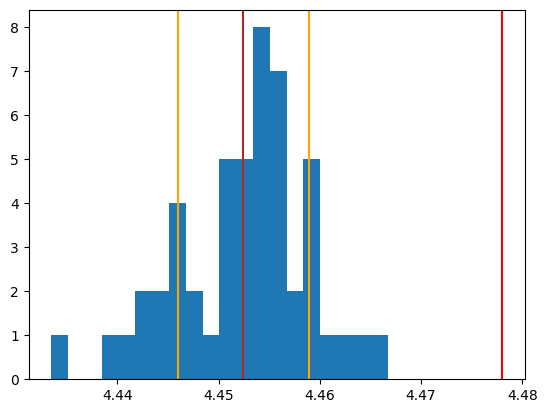

[4.45842609 4.45554077 4.46389737 4.45134692 4.44486363 4.44392003
 4.45346372 4.45544711 4.45145407 4.44656761 4.45788391 4.45420905
 4.46060533 4.44625367 4.45512939 4.45250981 4.45950957 4.45994049
 4.45188256 4.44625489 4.45596988 4.45781139 4.44215532 4.4557161
 4.44818449 4.45872309 4.43346034 4.44691798 4.44152137 4.45337237
 4.45247796 4.45026412 4.45561026 4.45359472 4.43948201 4.45473279
 4.44180375 4.44656792 4.45100687 4.45268307 4.45583007 4.45433024
 4.46668871 4.45499032 4.45948938 4.45450151 4.46248173 4.4484851
 4.45483472 4.45022728]


In [ ]:
m = np.mean(res)
s = np.std(res)
print(m)
print(s)
plt.hist(res,bins=20)
plt.axvline(x=4.478,c='red')
plt.axvline(x=m,c='brown')
plt.axvline(x=m-s,c='orange' )
plt.axvline(x=m+s,c='orange' )
plt.show()
print(res)

### h=50, 50 wycen, $n=1e5$, 40@AP , $s_0=36$, $r=0.06$, $\sigma=0.2$, $T=1$

In [ ]:
k = 50
h = 50
n = 1e5
res2 = np.zeros(k)
for i in range(k):
    S, Time = gen_traj(s0=s0,sig=sig,r=r,T=T,h=h,n=n)
    res2[i] = LS(S,Time,opt=opt)['LS']

4.545272814887092
0.005356505448602615


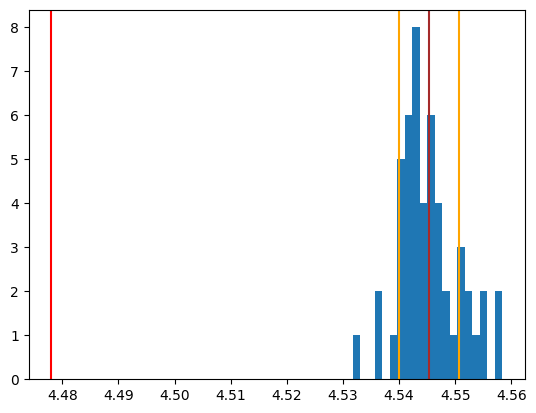

[4.53970412 4.55372592 4.54579542 4.54763691 4.5556177  4.54691649
 4.5470378  4.54970304 4.54791932 4.54538436 4.55037073 4.54620751
 4.54577633 4.55301813 4.54220589 4.55703991 4.54202097 4.54327703
 4.55483554 4.54030948 4.54068961 4.5401634  4.55045267 4.53677864
 4.53638171 4.54043121 4.54464735 4.54087048 4.54477541 4.5454116
 4.54261513 4.54336203 4.54240346 4.54163332 4.54309132 4.54507638
 4.54649929 4.54807941 4.55264514 4.54385658 4.5431391  4.55835312
 4.54416675 4.55130574 4.54125456 4.54198523 4.53171975 4.5414601
 4.54347008 4.54241959]


In [ ]:
m = np.mean(res2)
s = np.std(res2)
print(m)
print(s)
plt.hist(res2,bins=20)
plt.axvline(x=4.478,c='red')
plt.axvline(x=m,c='brown')
plt.axvline(x=m-s,c='orange' )
plt.axvline(x=m+s,c='orange' )
plt.show()
print(res2)

mój fd: 4.486634512751969

mój ls h=50: 4.5429481528562725

mój ls h=350: 4.452460417263011

paper fd: 4.478

paper ls: 4.472

### Śmieci

In [ ]:
r_dict = LS(opt=opt,s0=s0,K=K,r=r,sig=sig,T=T,h=100,n=1e6,poly_type='Laguerre')

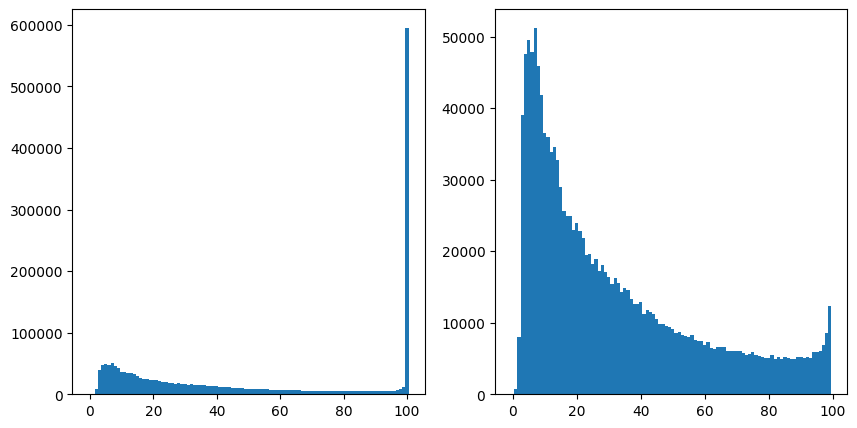

In [ ]:
_, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(r_dict['excercise'],bins=np.arange(0,102)-0.5)
ax[1].hist(r_dict['excercise'],bins=np.arange(0,101)-0.5)
plt.show()

(100000, 51)


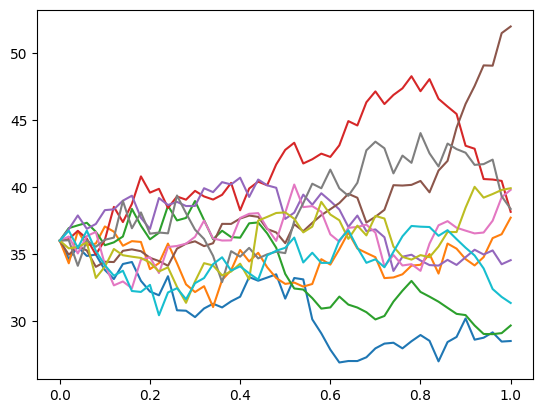

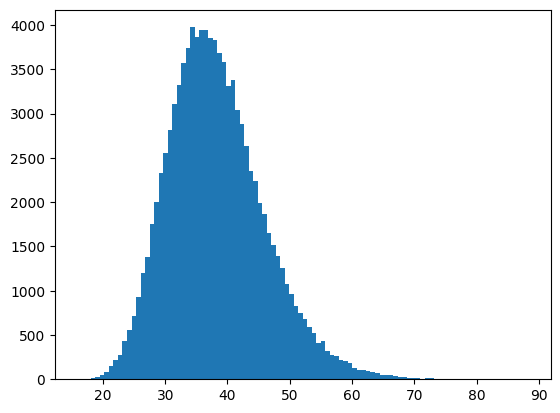

In [ ]:
S = r_dict['S']
print(S.shape)
Time= np.arange(0,1+1/50,1/50)
_, ax = plt.subplots(1,1)
for i in range(10):
    ax.plot(Time,S[i,:])
plt.show()

plt.hist(S[:,-1],bins=100)
plt.show()

(500, 20002)


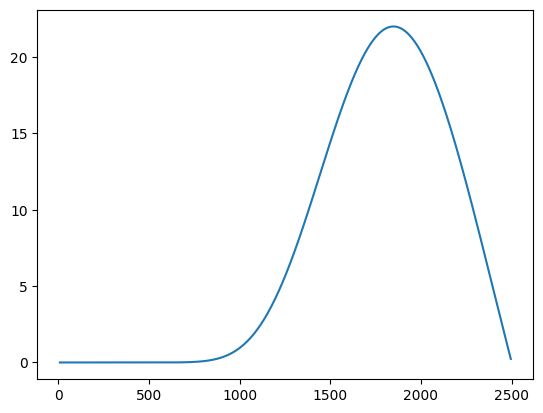

In [ ]:
S = res['S']
allV = res['values']
V = allV[1:-1,0]
print(allV.shape)
plt.plot(S,V)
plt.show()

In [ ]:
print(np.mean(S[:,-1]))
print(np.std(S[:,-1]))
print(s0*np.exp(r*T))
print(s0*np.exp(r*T)*np.sqrt((np.exp(sig**2*T)-1)))

38.19777212830559
7.746585436038475
38.22611567563295
7.7223163078518855
